In [40]:
import pandas as pd
pokemon_df = pd.read_csv('pokemon.csv')
pokemon_df

,abilities,against_bug,against_dark,against_dragon,against_electric,against_fairy,against_fight,against_fire,against_flying,against_ghost,...,percentage_male,pokedex_number,sp_attack,sp_defense,speed,type1,type2,weight_kg,generation,is_legendary
0,"['Overgrow', 'Chlorophyll']",1.00,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,1,65,65,45,grass,poison,6.9,1,0
1,"['Overgrow', 'Chlorophyll']",1.00,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,2,80,80,60,grass,poison,13.0,1,0
2,"['Overgrow', 'Chlorophyll']",1.00,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,3,122,120,80,grass,poison,100.0,1,0
3,"['Blaze', 'Solar Power']",0.50,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,...,88.1,4,60,50,65,fire,NaN,8.5,1,0
4,"['Blaze', 'Solar Power']",0.50,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,...,88.1,5,80,65,80,fire,NaN,19.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796,['Beast Boost'],0.25,1.0,0.5,2.0,0.5,1.0,2.0,0.5,1.0,...,NaN,797,107,101,61,steel,flying,999.9,7,1
797,['Beast Boost'],1.00,1.0,0.5,0.5,0.5,2.0,4.0,1.0,1.0,...,NaN,798,59,31,109,grass,steel,0.1,7,1
798,['Beast Boost'],2.00,0.5,2.0,0.5,4.0,2.0,0.5,1.0,0.5,...,NaN,799,97,53,43,dark,dragon,888.0,7,1
799,['Prism Armor'],2.00,2.0,1.0,1.0,1.0,0.5,1.0,1.0,2.0,...,NaN,800,127,89,79,psychic,NaN,230.0,7,1


In [41]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt

In [42]:
class MaskDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.images = []
        self.labels = []

        for img_name in os.listdir(data_dir):
            img_path = os.path.join(data_dir, img_name)
            self.images.append(img_path)
            self.labels.append(0) 

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [43]:
data_dir = 'Train'

In [44]:
# Định nghĩa các phép biến đổi ảnh
transform = transforms.Compose([
    transforms.Resize((150, 150)),  # Resize ảnh về 150x150
    transforms.ToTensor(),  # Chuyển thành tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Chuẩn hóa
])

# Khởi tạo dataset
dataset = MaskDataset(data_dir="Train", transform=transform)
print(f"Tổng số mẫu: {len(dataset)}")

Tổng số mẫu: 819


In [45]:
# 3. Khởi tạo Dataset
data_dir = "Train"  # Thư mục chứa ảnh
dataset = MaskDataset(data_dir=data_dir, transform=transform)

In [46]:
# 4. Chia thành tập huấn luyện (80%) và tập kiểm tra (20%)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [47]:
# 5. Tạo DataLoader cho tập huấn luyện và kiểm tra
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [48]:
# 6. Kiểm tra số lượng mẫu trong từng tập
print(f"Tổng số mẫu: {len(dataset)}")
print(f"Số mẫu tập huấn luyện: {len(train_dataset)}")
print(f"Số mẫu tập kiểm tra: {len(test_dataset)}")

Tổng số mẫu: 819
Số mẫu tập huấn luyện: 655
Số mẫu tập kiểm tra: 164


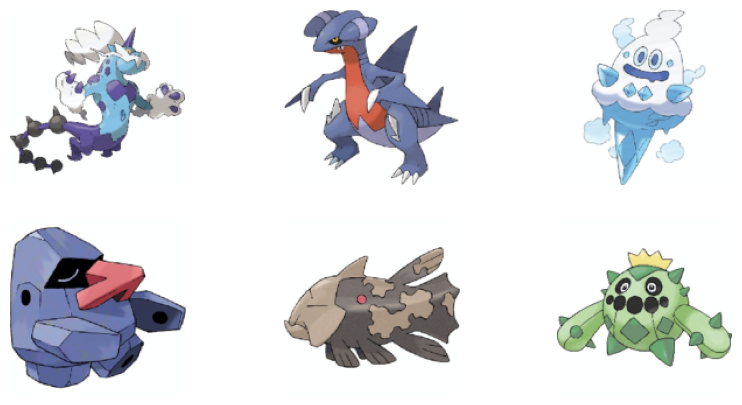

In [49]:
# Lấy một batch dữ liệu từ train_loader
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Chuyển tensor về ảnh
def imshow(img):
    img = img.numpy().transpose((1, 2, 0))  # Đưa về dạng H x W x C
    mean = np.array([0.485, 0.456, 0.406])  # Giá trị chuẩn hóa
    std = np.array([0.229, 0.224, 0.225])
    img = img * std + mean  # Bỏ chuẩn hóa
    img = np.clip(img, 0, 1)  # Giới hạn giá trị trong khoảng [0,1]
    plt.imshow(img)
    plt.axis("off")

# Hiển thị 6 ảnh đầu tiên
plt.figure(figsize=(10, 5))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    imshow(images[i])
plt.show()

In [50]:
#  FakeData có nhãn hợp lý hơn
class CustomFakeDataset(Dataset):
    def __init__(self, size=1000, transform=None):
        self.data = torchvision.datasets.FakeData(size=size, image_size=(3, 72, 72), transform=transform)
        self.targets = torch.randint(0, 2, (size,))  # Sửa nhãn hợp lý hơn

    def __getitem__(self, index):
        img, _ = self.data[index]
        label = self.targets[index]
        return img, label

    def __len__(self):
        return len(self.data)

#  Chuẩn bị dữ liệu
transform = transforms.Compose([
    transforms.Resize((72, 72)),
    transforms.ToTensor(),
])

train_dataset = CustomFakeDataset(size=1000, transform=transform)
test_dataset = CustomFakeDataset(size=300, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

#  Định nghĩa CNN
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1, 1)
        self.conv3 = nn.Conv2d(64, 128, 3, 1, 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 9 * 9, 512)
        self.fc2 = nn.Linear(512, 1)  # KHÔNG sigmoid ở đây

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)  # KHÔNG sigmoid
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)

criterion = nn.BCEWithLogitsLoss()  #  Dùng BCEWithLogitsLoss
optimizer = optim.Adam(model.parameters(), lr=0.001)

n_epochs = 50
train_losses = []
test_losses = []
test_accuracies = []

# Huấn luyện mô hình
for epoch in range(n_epochs):
    model.train()
    train_loss = 0.0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device).view(-1, 1).float()

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # Đánh giá mô hình
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device).view(-1, 1).float()

            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item() * inputs.size(0)

            preds = (torch.sigmoid(outputs) > 0.5).float()  # Sigmoid tại đây
            correct += (preds == targets).sum().item()
            total += targets.size(0)

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    accuracy = correct / total
    test_accuracies.append(accuracy)

    print(f"Epoch {epoch+1}/{n_epochs} - Train Loss: {train_loss:.4f} - Test Loss: {test_loss:.4f} - Accuracy: {accuracy:.4f}")


Epoch 1/50 - Train Loss: 0.7008 - Test Loss: 0.6928 - Accuracy: 0.5133
Epoch 2/50 - Train Loss: 0.6932 - Test Loss: 0.6931 - Accuracy: 0.5133
Epoch 3/50 - Train Loss: 0.6932 - Test Loss: 0.6931 - Accuracy: 0.5133
Epoch 4/50 - Train Loss: 0.6931 - Test Loss: 0.6930 - Accuracy: 0.5133
Epoch 5/50 - Train Loss: 0.6933 - Test Loss: 0.6930 - Accuracy: 0.5133
Epoch 6/50 - Train Loss: 0.6931 - Test Loss: 0.6930 - Accuracy: 0.5133
Epoch 7/50 - Train Loss: 0.6952 - Test Loss: 0.6930 - Accuracy: 0.5133
Epoch 8/50 - Train Loss: 0.6932 - Test Loss: 0.6931 - Accuracy: 0.5133
Epoch 9/50 - Train Loss: 0.6932 - Test Loss: 0.6930 - Accuracy: 0.5133
Epoch 10/50 - Train Loss: 0.6931 - Test Loss: 0.6930 - Accuracy: 0.5133
Epoch 11/50 - Train Loss: 0.6931 - Test Loss: 0.6930 - Accuracy: 0.5133
Epoch 12/50 - Train Loss: 0.6932 - Test Loss: 0.6930 - Accuracy: 0.5133
Epoch 13/50 - Train Loss: 0.6931 - Test Loss: 0.6930 - Accuracy: 0.5133
Epoch 14/50 - Train Loss: 0.6931 - Test Loss: 0.6930 - Accuracy: 0.5133
E

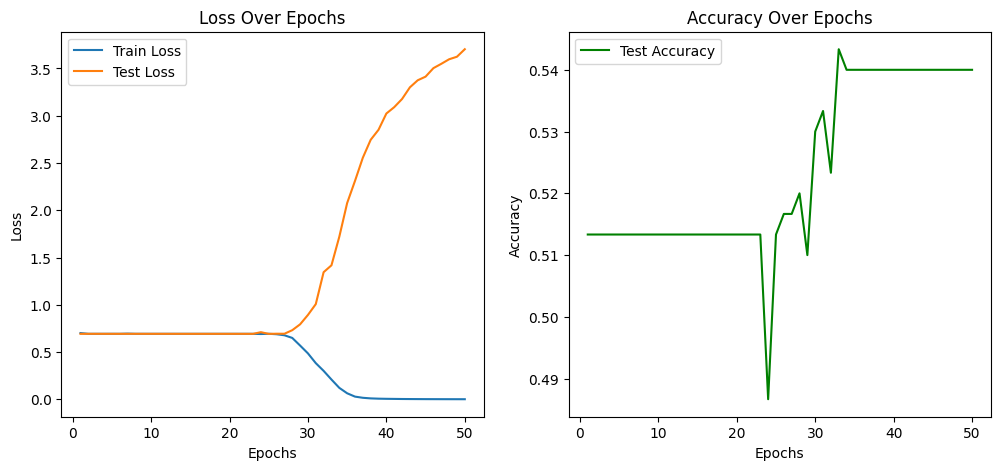

In [51]:
# Vẽ biểu đồ Loss và Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, n_epochs+1), train_losses, label="Train Loss")
plt.plot(range(1, n_epochs+1), test_losses, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Over Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, n_epochs+1), test_accuracies, label="Test Accuracy", color="green")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Over Epochs")
plt.legend()

plt.show()


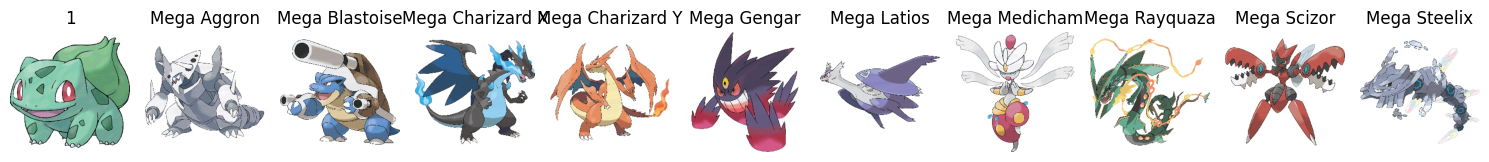

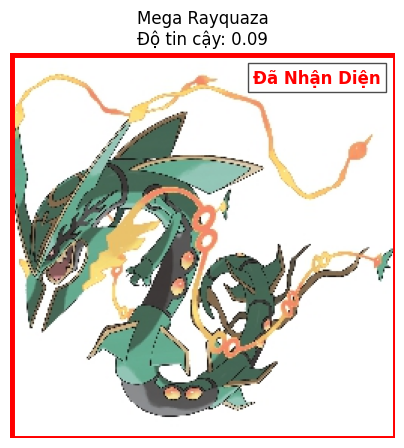

In [2]:
import os
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision import transforms
from PIL import Image

# Xác định thiết bị sử dụng (CPU hoặc GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Chuyển đổi hình ảnh về dạng phù hợp cho mô hình
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Định nghĩa mô hình CNN để phân loại Pokémon
class MegaPokemonClassifier(nn.Module):
    def __init__(self, so_luong_loai):
        super(MegaPokemonClassifier, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, so_luong_loai)
        )
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Hàm dự đoán Pokémon từ ảnh đầu vào
def du_doan_pokemon(duong_dan_anh, mo_hinh, chuyen_doi):
    anh = Image.open(duong_dan_anh).convert("RGB")
    anh_tensor = chuyen_doi(anh).unsqueeze(0).to(device)
    mo_hinh.eval()
    with torch.no_grad():
        dau_ra = mo_hinh(anh_tensor)
        xac_suat = torch.softmax(dau_ra, dim=1)
        xac_suat_cao_nhat, loai_du_doan = torch.max(xac_suat, 1)
    return loai_du_doan.item(), xac_suat_cao_nhat.item(), anh

# Hàm lấy danh sách tất cả Pokémon từ thư mục
def lay_danh_sach_pokemon(thumuc):
    return [os.path.splitext(f)[0] for f in os.listdir(thumuc) if f.endswith(('.jpg', '.jpeg', '.png'))]

# Khởi tạo mô hình theo số lượng Pokémon tìm thấy
danh_sach_pokemon = lay_danh_sach_pokemon("Test")
mo_hinh = MegaPokemonClassifier(so_luong_loai=len(danh_sach_pokemon)).to(device)

# Hàm hiển thị tất cả Pokémon trong thư mục
def hien_thi_danh_sach_pokemon(thumuc):
    hinh_anh = [f for f in os.listdir(thumuc) if f.endswith(('.jpg', '.jpeg', '.png'))]
    fig, axes = plt.subplots(1, len(hinh_anh), figsize=(15, 5))
    if len(hinh_anh) == 1:
        axes = [axes]
    
    for idx, file_anh in enumerate(hinh_anh):
        duong_dan_anh = os.path.join(thumuc, file_anh)
        anh = Image.open(duong_dan_anh)
        axes[idx].imshow(anh)
        axes[idx].set_title(os.path.splitext(file_anh)[0])
        axes[idx].axis("off")
    
    plt.tight_layout()
    plt.show()

# Hàm hiển thị dự đoán theo tên Pokémon
def hien_thi_pokemon_ten_nhap(thumuc, ten_pokemon):
    if not ten_pokemon.startswith("Mega"):
        print("⚠️ CẢNH BÁO: Không hợp lệ!")
        return
    
    duong_dan_anh = os.path.join(thumuc, ten_pokemon + ".jpg")
    if not os.path.exists(duong_dan_anh):
        print(f"Không tìm thấy ảnh: {duong_dan_anh}")
        return
    
    loai_du_doan, do_tin_cay, anh = du_doan_pokemon(duong_dan_anh, mo_hinh, transform)
    plt.figure(figsize=(5, 5))
    plt.imshow(anh)
    plt.title(f"{ten_pokemon}\nĐộ tin cậy: {do_tin_cay:.2f}")
    
    # Thêm chữ "Đã Nhận Diện" ở góc trên bên phải
    plt.text(anh.size[0] - 10, 10, "Đã Nhận Diện", color='red', fontsize=12, ha='right', va='top', fontweight='bold', bbox=dict(facecolor='white', alpha=0.7))
    
    plt.axis("off")
    
    # Xác định màu viền dựa trên độ tin cậy
    mau_vien = 'green' if do_tin_cay > 0.7 else 'yellow' if do_tin_cay > 0.5 else 'red'
    hcn = patches.Rectangle((0, 0), anh.size[0], anh.size[1], linewidth=5, edgecolor=mau_vien, facecolor='none')
    plt.gca().add_patch(hcn)
    
    plt.show()

# Hiển thị tất cả Pokémon trong thư mục
hien_thi_danh_sach_pokemon("Test")
# Yêu cầu người dùng nhập tên Pokémon
ten_pokemon_nhap = input("Nhập tên Pokémon cần nhận diện: ")
hien_thi_pokemon_ten_nhap("Test", ten_pokemon_nhap)